In [1]:
#computer vision
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# 1) Getting Data

In [2]:
#setup data

train_data = torchvision.datasets.FashionMNIST(
    root='data',# where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=torchvision.transforms.ToTensor(), #turn into tensors
    target_transform=None # ou can transform labels
)

test_data=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.50MB/s]


In [3]:
len(train_data),len(test_data)

(60000, 10000)

In [4]:
classess = train_data.classes
classess

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## 1.2) Visualize

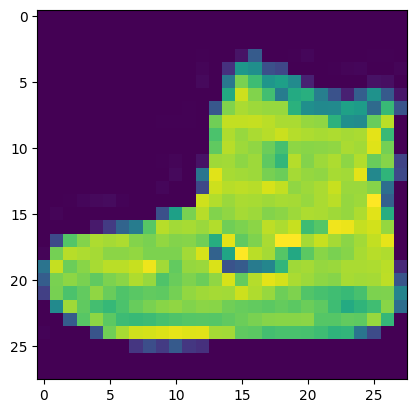

In [5]:
image , label = train_data[0]
plt.imshow(image.squeeze())

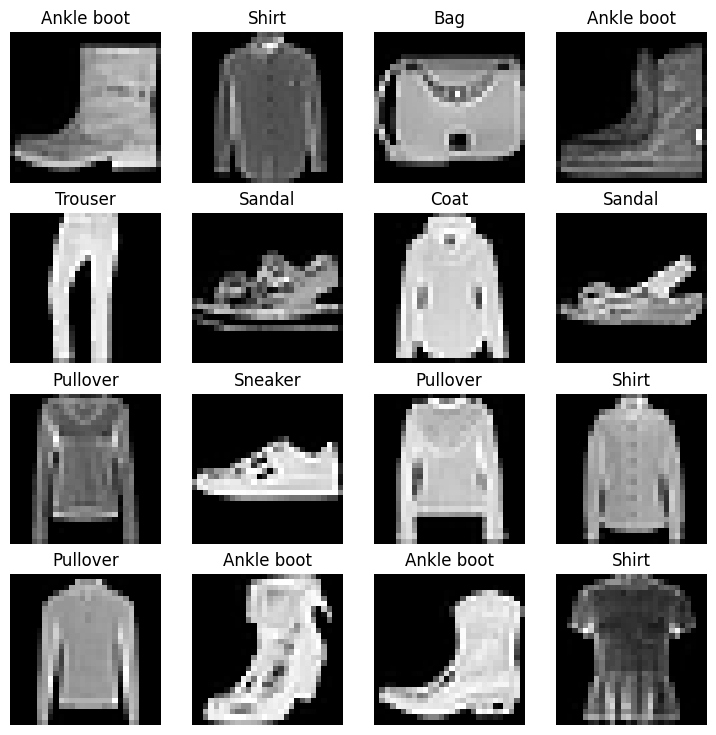

In [6]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classess[label])
    plt.axis(False);


## 1.3) Dataloader

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

(train_dataloader) , test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x78ef9c5b7c50>,
 <torch.utils.data.dataloader.DataLoader at 0x78ef9c3e6890>)

In [8]:
train_features_batch , train_label_batch = next(iter(train_dataloader))

train_features_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# 2) Building baseline model

In [9]:
#create a flatten layer
flatten_model = nn.Flatten()

x = train_features_batch
x.shape

#ouput
output = flatten_model(x)
output.shape

print(f'x shape :{x.shape}')
print(f'output shape :{output.shape}')

x shape :torch.Size([32, 1, 28, 28])
output shape :torch.Size([32, 784])


In [10]:
class FashionMNISModelV0(nn.Module):
  def __init__(self,input_shape:int,
               hidden_units: int,
               output_shape : int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features = input_shape,
                out_features = hidden_units),
      nn.Linear(in_features = hidden_units,
                out_features = output_shape),

  )

  def forward(self,x):
    return self.layer_stack(x)


In [11]:
torch.manual_seed(42)


model_0 = FashionMNISModelV0(input_shape=784,hidden_units=10,output_shape=len(classess)).to("cpu")

model_0

FashionMNISModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

# 3) Setup loss function and optimizer

## 3.1) Loss function and optimizeer

In [12]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


In [13]:
from helper_functions import accuracy_fn

loss = nn.CrossEntropyLoss()

op = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

## 3.2) Timing our experiment

In [14]:
from timeit import default_timer as timer
def timecal(start:float,
            end: float,
            device: torch.device=None):
  total_time = end - start
  print(f'train time on device: {device} = {total_time:.3f} seconds' )
  return total_time

In [15]:
start_time=timer()

end_time = timer()
timecal(start=start_time,end=end_time,device="cpu")

train time on device: cpu = 0.000 seconds


6.303199999990738e-05

## 3.3) Training loop

In [16]:
from tqdm.auto import tqdm

torch.manual_seed(42)
start_time_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):

  train_loss = 0

  for batch,(X,y) in enumerate(train_dataloader):
    model_0.train()

    #step 1
    y_pred= model_0(X)

    #step 2
    ls = loss(y_pred,y)
    train_loss += ls

    #step 3
    op.zero_grad()

    #step 4
    ls.backward()

    #step 5
    op.step()

     # Print out how many samples have been seen
    if batch % 400 == 0:
       print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)

  #testin

  test_loss, test_acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:

      #step 1
      y_pred_test = model_0(X_test)

      #step2
      test_loss += loss(y_pred_test,y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=y_pred_test.argmax(dim=1))


    # Calculations on test metrics need to happen inside torch.inference_mode()
    # Divide total test loss by length of test dataloader (per batch)
    test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
    test_acc /= len(test_dataloader)


      ## Print out what's happening
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = timecal(start=start_time_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

train time on device: cpu = 29.644 seconds


# 4) prediction and Results

In [17]:
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss :torch.nn.Module,
               accuracy_fn):
  ls , acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      y_pred = model(X)

      ls += loss(y_pred,y)
      acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
    loss = ls/len(data_loader)
    acc = acc/len(data_loader)
  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

results = eval_model(model=model_0,
                     data_loader=test_dataloader,
                     loss=loss,
                     accuracy_fn=accuracy_fn)
results

{'model_name': 'FashionMNISModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 5) Building a better model : Model 1

In [19]:
class FashionMNISModelV1(torch.nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_shape),
            nn.ReLU(),
        )
    def forward(self,x:torch.Tensor):
        return self.layer_stack(x)


In [20]:
torch.manual_seed(42)
model_1 = FashionMNISModelV1(input_shape=784,
                             hidden_units=10,
                         output_shape= len(classess)).to(device)

next(model_1.parameters()).device

device(type='cpu')

## 5.1) Setup Loss function and Opyimizer

In [21]:
from helper_functions import accuracy_fn
loss = nn.CrossEntropyLoss()
op = torch.optim.SGD(params= model_1.parameters(),lr=0.1)

## 5.2) functionize training and testing loop

In [22]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss: torch.nn.Module,
               accuracy_fn,
               op : torch.optim.Optimizer,
               device: torch.device=device):
    train_loss, train_acc= 0,0
    for batch,(X,y) in enumerate(data_loader):

        X,y = X.to(device), y.to(device)

        model.train()

        #forward pass

        y_pred = model(X)

        #loss
        ls = loss(y_pred,y)
        train_loss += ls
        train_acc += accuracy_fn(y_true=y,
                             y_pred= y_pred.argmax(dim=1))

        #zerp grad
        op.zero_grad()

        #backpropagation
        ls.backward()

        #Optimizer

        op.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss : {train_loss:.5f} | Train acc: {train_acc:.2f}%')

In [23]:
def test_step(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss:torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
    test_loss,test_acc = 0,0


    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:

            X,y = X.to(device), y.to(device)

            y_test = model(X)

            test_loss += loss(y_test,y)
            test_acc += accuracy_fn(y_true=y,y_pred=y_test.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")')

In [24]:
torch.manual_seed(42)
from timeit import default_timer as timer
start_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch} -----------------------------------------------')

    train_step(model= model_1,
               data_loader = train_dataloader,
               loss = loss,
               accuracy_fn=accuracy_fn,
               op = op,
               device = device)


    test_step(model= model_1,
              data_loader = test_dataloader,
              loss = loss,
              accuracy_fn = accuracy_fn,
              device = device)

end_gpu = timer()
total_time = timecal(start=start_gpu,end=end_gpu,device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 -----------------------------------------------
Train loss : 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%
")
Epoch: 1 -----------------------------------------------
Train loss : 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%
")
Epoch: 2 -----------------------------------------------
Train loss : 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%
")
train time on device: cpu = 31.846 seconds


# 6) Builing a CNN

In [25]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape:int,hidden_units: int ,output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units *7*7,
                       out_features=output_shape)
        )
    def forward(self,x):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x= self.classifier(x)
      return x



In [26]:
model_2= FashionMNISTModelV2(input_shape=1,
                             hidden_units=10,
                             output_shape=len(classess)).to(device)

In [27]:
torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [28]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size= 3,
                       stride= 1,
                       padding= 0)

out_layer = conv_layer(test_image.unsqueeze(dim=0))
out_layer.shape

torch.Size([1, 10, 62, 62])

In [29]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")



Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


## 6.2) Loss func and op

In [30]:
loss = nn.CrossEntropyLoss()
op = torch.optim.SGD(params=model_2.parameters(),lr=0.1)

## 6.3) training and testing

In [31]:
torch.manual_seed(42)
from timeit import default_timer as timer

model_2_timer = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f'epoch : {epoch} -------------------------------')

  train_step(model=model_2,
             data_loader= train_dataloader,
             loss=loss,
             accuracy_fn=accuracy_fn,
             op=op,
             device=device

  )

  test_step(model=model_2,
             data_loader= test_dataloader,
             loss=loss,
             accuracy_fn=accuracy_fn,
             device=device)

model_2_end=timer()

total_time=timecal(start=model_2_timer,end=model_2_end,device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 0 -------------------------------
Train loss : 0.58923 | Train acc: 78.73%
Test loss: 0.40914 | Test accuracy: 85.32%
")
epoch : 1 -------------------------------
Train loss : 0.37348 | Train acc: 86.61%
Test loss: 0.37043 | Test accuracy: 86.43%
")
epoch : 2 -------------------------------
Train loss : 0.33831 | Train acc: 87.75%
Test loss: 0.33472 | Test accuracy: 87.86%
")
train time on device: cpu = 155.881 seconds


In [32]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [33]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classess[test_labels[0]]})")


Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


# 7) confusin matrix

In [34]:
import tqdm.auto as tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm.tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)

        #forward pass

        y_logit = model_2(X)

        y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)

        y_preds.append(y_pred.cpu())


y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

In [35]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.8 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [36]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [37]:
all_preds = []
all_labels = []

model_2.eval()
with torch.inference_mode():
    for X_test, y_test in test_dataloader:
        y_pred = model_2(X_test.to(device)).argmax(dim=1)
        all_preds.append(y_pred.cpu())
        all_labels.append(y_test.cpu())

y_pred_tensor = torch.cat(all_preds)
y_true_tensor = torch.cat(all_labels)

confmat = ConfusionMatrix(num_classes=10, task='multiclass')
confmat_tensor = confmat(y_pred_tensor, y_true_tensor)
confmat_tensor

tensor([[853,   2,   7,  34,   7,   1,  85,   0,  11,   0],
        [  1, 976,   1,  15,   1,   0,   4,   0,   2,   0],
        [ 13,   0, 732,   9, 138,   0, 105,   0,   3,   0],
        [ 20,   6,   9, 910,  18,   0,  36,   0,   1,   0],
        [  0,   1,  45,  47, 822,   0,  84,   0,   1,   0],
        [  0,   0,   0,   0,   0, 966,   1,  22,   3,   8],
        [163,   0,  54,  35,  84,   1, 639,   0,  24,   0],
        [  0,   0,   0,   0,   0,  17,   0, 964,   1,  18],
        [  2,   2,   1,   7,   5,   2,   2,   4, 975,   0],
        [  0,   0,   0,   0,   0,   3,   1,  46,   2, 948]])

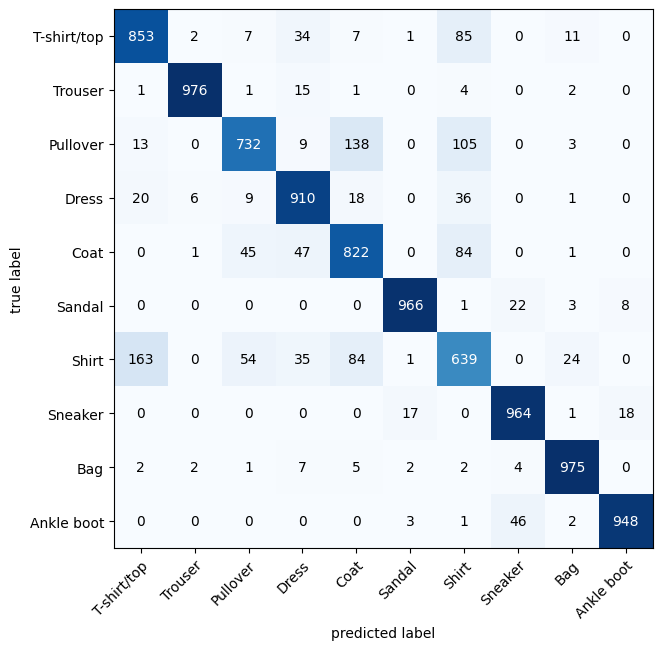

In [38]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classess, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [39]:
from pathlib import Path
MODEL_PATH = Path("models")

MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "PyTorch_Computer_Vision_and_CNN.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)